<a href="https://colab.research.google.com/github/QorbQuant/Crypto-tax-data/blob/main/StellarAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stellar_sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.0/496.0 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.9 MB/s eta 0:00:00
  Created wheel for stellar-base-sseclient: filename=stellar_base_sseclient-0.0.21-py3-none-any.whl size=5490 sha256=bc6e04899ee56f03ba51db85485b33c16b2e4b4f6b09f46dd10f428acf3b1a01
  Stored in directory: /root/.cache/pip/wheels/6b/66/65/b8fe1825b1731341f6b91d8c887a40a876266f3cd8b1c231f0
Successfully built stellar-base-sseclient
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Success

In [ ]:
!pip install --upgrade stellar_sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import stellar_sdk
from stellar_sdk import Server
print(stellar_sdk.__version__)

8.1.1


In [ ]:
#@title requirements

import requests
import pandas as pd
import time
from google.colab import data_table
import numpy as np

from stellar_sdk import Server


data_table.enable_dataframe_formatter()

In [ ]:
wallet = "GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5R5UKI4T7SD"
# wallet = "GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7"
# wallet = "GBK4AYTOYIAYT4UJECSQGMACUWLKYOOM4VCAUUZ3Y3FG5XD2LYK3FGK2"


In [ ]:

server = Server(horizon_url="https://horizon.stellar.org")

account = wallet

# paging
payments_records = []
payments_call_builder = (
    server.payments().for_account(account).order(desc=False).limit(10)
)  # limit can be set to a maximum of 200
payments_records += payments_call_builder.call()["_embedded"]["records"]
page_count = 0
while page_records := payments_call_builder.next()["_embedded"]["records"]:
    payments_records += page_records
    page_count += 1

df = pd.DataFrame(payments_records)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='created_at', ascending=False)

In [ ]:
### for create account #####

create_acc_df = df.query("type == 'create_account'").copy()

create_acc_df.loc[:, 'transactionType'] = np.where(
    create_acc_df.loc[:, 'funder'] == wallet,
    'withdrawal',
    'deposit'
)

create_acc_df.loc[:, 'public_key'] = wallet
create_acc_df.loc[:, 'amountTicker'] = 'XLM'
create_acc_df.drop(columns=['amount'], inplace=True)

create_acc_df.rename(columns = {'starting_balance':'amount'}, inplace=True)

create_acc_df = create_acc_df[['created_at', 'public_key', 'amount', 'amountTicker', 'transaction_hash', 'transactionType']]

#### END create account ####


In [ ]:
## Rules for Payment df ####

payment_df = df.query("type == 'payment'").copy()

payment_df.loc[:, 'transactionType'] = np.where(
    payment_df.loc[:, 'from'] == wallet,
    'withdrawal',
    'deposit'
)

payment_df.loc[:, 'public_key'] = wallet

payment_df.rename(columns = {'asset_code': 'amountTicker'}, inplace=True)

payment_df = payment_df[['created_at', 'public_key', 'amount', 'amountTicker', 'transaction_hash', 'transactionType']]

payment_df['amountTicker'].fillna('XLM', inplace=True)

#### END payment df ####

In [ ]:
## Rules for Pyament strict receive df ###

if 'path_payment_strict_receive' in df['type'].unique():
    payment_receive_df = df.loc[df['type'] == 'path_payment_strict_receive']

    if (payment_receive_df['from'] == payment_receive_df['to']).any():

      condition = payment_receive_df['from'] == payment_receive_df['to']
      new_df = payment_receive_df[condition]

      # Create deposit dataframe
      deposits = new_df[['created_at','to', 'amount', 'asset_code', 'transaction_hash']].copy()
      deposits['transactionType'] = 'deposit'
      deposits.rename(columns={'to': 'public_key', 'amount': 'amount', 'asset_code': 'amountTicker'}, inplace=True)

      # Create withdrawal dataframe
      withdrawals = new_df[['created_at','from', 'source_amount', 'source_asset_code', 'transaction_hash']].copy()
      withdrawals['transactionType'] = 'withdrawal'
      withdrawals.rename(columns={'from': 'public_key', 'source_amount': 'amount', 'source_asset_code': 'amountTicker'}, inplace=True)

      # Append deposit and withdrawal dataframes
      receive_df = deposits.append(withdrawals)

      receive_df = receive_df.sort_values(by='created_at', ascending=False)

      # Group by transaction_hash
      receive_df['group_index'] = receive_df.groupby('transaction_hash').cumcount()

      # Create unique identifier for each transaction
      receive_df['transaction_hash'] = receive_df['transaction_hash'] + '-' + receive_df['group_index'].apply(str)

      receive_df['amountTicker'].fillna('XLM', inplace=True)

      receive_df.drop('group_index', axis=1, inplace=True)

    else:
      receive_df = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transactionType', 'transaction_hash'])

    ## WHERE Asset code and source asset code are the same
    if (payment_receive_df['to'] != payment_receive_df['from']).any():

      condition_2 = payment_receive_df['to'] != payment_receive_df['from']
      new_df_2 = payment_receive_df[condition_2]

      new_df_2.loc[:, 'transactionType'] = np.where(
        new_df_2.loc[:, 'from'] == wallet,
        'withdrawal',
        'deposit'
        )

      new_df_2.loc[:, 'public_key'] = wallet

      new_df_2.rename(columns = {'asset_code': 'amountTicker'}, inplace=True)

      new_df_2 = new_df_2[['created_at', 'public_key', 'amount', 'amountTicker', 'transaction_hash', 'transactionType']]

      new_df_2['amountTicker'].fillna('XLM', inplace=True)

      # receive_df = new_df_2.append(receive_df)

      # receive_df = receive_df.sort_values(by='created_at', ascending=False)

      # receive_df.drop('group_index', axis=1, inplace=True)
    else:
      new_df_2 = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transactionType', 'transaction_hash'])

    # Append deposit/withdrawal and path payment dataframes
    receive_df = new_df_2.append(receive_df)

    # Sort by created_at and reset the index
    receive_df = receive_df.sort_values(by='created_at', ascending=False).reset_index(drop=True)

else:
    receive_df = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transactionType', 'transaction_hash'])


#### END strict receive ####

In [ ]:
## Rules for Pyament strict send df ####
if 'path_payment_strict_send' in df['type'].unique():
  payment_send_df = df.loc[df['type'] == 'path_payment_strict_send']

  # Create deposit dataframe
  deposits_send = payment_send_df[['created_at','to', 'amount', 'asset_code', 'transaction_hash']].copy()
  deposits_send['transactionType'] = 'deposit'
  deposits_send.rename(columns={'to': 'public_key', 'amount': 'amount', 'asset_code': 'amountTicker'}, inplace=True)

  # Check for NaN values in amountTicker and fill it with 'XTZ'
  deposits_send['amountTicker'].fillna('XLM', inplace = True)

  # Create withdrawal dataframe
  withdrawals_send = payment_send_df[['created_at','from', 'source_amount', 'source_asset_code', 'transaction_hash']].copy()
  withdrawals_send['transactionType'] = 'withdrawal'
  withdrawals_send.rename(columns={'from': 'public_key', 'source_amount': 'amount', 'source_asset_code': 'amountTicker'}, inplace=True)

  # Check for NaN values in amountTicker and fill it with 'XTZ'
  withdrawals_send['amountTicker'].fillna('XLM', inplace = True)

  # Append deposit and withdrawal dataframes
  withdrawals_send = deposits_send.append(withdrawals_send)


  withdrawals_send = withdrawals_send.sort_values(by='created_at', ascending=False)

  # Group by transaction_hash
  withdrawals_send['group_index'] = withdrawals_send.groupby('transaction_hash').cumcount()

  # Create unique identifier for each transaction
  withdrawals_send['transaction_hash'] = withdrawals_send['transaction_hash'] + '-' + withdrawals_send['group_index'].apply(str)

  withdrawals_send['amountTicker'].fillna('XLM', inplace=True)

  withdrawals_send.drop('group_index', axis=1, inplace=True)
else:
    withdrawals_send = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transactionType', 'transaction_hash'])

### END payment Strict Receive ####


In [ ]:
## GET TRADES FOR ACCT ###
trades_records = []
trades_call_builder = (
    server.trades().for_account(account).order(desc=False).limit(10)
)  # limit can be set to a maximum of 200
trades_records += trades_call_builder.call()["_embedded"]["records"]
page_count = 0
while page_records := trades_call_builder.next()["_embedded"]["records"]:
    trades_records += page_records
    page_count += 1

trades_df = pd.DataFrame(trades_records)

In [ ]:
def transform_df(df, public_key):
    deposit_df = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transaction_hash', 'transactionType'])
    withdrawal_df = pd.DataFrame(columns=['created_at', 'public_key', 'amount', 'amountTicker', 'transaction_hash', 'transactionType'])

    for i, trade in df.iterrows():
        if trade['base_is_seller']:
            deposit_df = deposit_df.append({
                'created_at': trade['ledger_close_time'],
                'public_key': trade['base_account'],
                'amount': trade['counter_amount'],
                'amountTicker': trade['counter_asset_code'],
                'transaction_hash': trade['id'],
                'transactionType': 'deposit'
            }, ignore_index=True)
            withdrawal_df = withdrawal_df.append({
                'created_at': trade['ledger_close_time'],
                'public_key': trade['base_account'],
                'amount': trade['base_amount'],
                'amountTicker': trade['base_asset_code'],
                'transaction_hash': trade['id'],
                'transactionType': 'withdrawal'
            }, ignore_index=True)
        else:
            deposit_df = deposit_df.append({
                'created_at': trade['ledger_close_time'],
                'public_key': trade['counter_account'],
                'amount': trade['base_amount'],
                'amountTicker': trade['base_asset_code'],
                'transaction_hash': trade['id'],
                'transactionType': 'deposit'
            }, ignore_index=True)
            withdrawal_df = withdrawal_df.append({
                'created_at': trade['ledger_close_time'],
                'public_key': trade['counter_account'],
                'amount': trade['counter_amount'],
                'amountTicker': trade['counter_asset_code'],
                'transaction_hash': trade['id'],
                'transactionType': 'withdrawal'
            }, ignore_index=True)

    deposit_df = deposit_df[deposit_df['public_key'] == public_key]
    withdrawal_df = withdrawal_df[withdrawal_df['public_key'] == public_key]

    combined_df = pd.concat([deposit_df, withdrawal_df])

    return combined_df

combine_df = transform_df(trades_df, wallet)

In [ ]:
frames = [create_acc_df, payment_df, receive_df, withdrawals_send, combine_df]

result = pd.concat(frames)
result['created_at'] = pd.to_datetime(result['created_at'], utc=True)
result['amount'] = pd.to_numeric(result['amount'], errors='coerce')
result.sort_values(by='created_at', ascending=False, inplace=True)
result.reset_index(drop=True, inplace=True)



In [ ]:
df = result
accountid = 'test'
id = 'test'

df = df.assign(fee = '')
df = df.assign(feeTicker = '')
df = df.assign(cost = '')
df = df.assign(costTicker = '')
df = df.assign(memo = '') #might turn into a f string variable
df = df.assign(accountId = f'{accountid}') #account id is wallet id from BitWave
df = df.assign(contactId = '')
df = df.assign(categoryId = '')
df = df.assign(remoteContactId = '')
df = df.assign(taxExempt = 'FALSE')
df = df.assign(id = f'{id}')
df['rownum'] = np.arange(df.shape[0])
df['id'] = df['id'] + df['rownum'].astype(str)
df.drop('rownum', axis=1, inplace=True)

df.rename(columns = {'created_at': 'time', 'transaction_hash': 'blockchainId',}, inplace=True)

df = df[['id','remoteContactId','amount','amountTicker','cost','costTicker','fee','feeTicker','time','blockchainId','memo','transactionType','accountId','contactId','categoryId','taxExempt']]
df = df.sort_values(by='time', ascending=False)



In [ ]:
rec = result

In [ ]:
df = df[['time', 'amount', 'amountTicker', 'transactionType']]

# merged_df = pd.merge(balance_df, df, how='left', left_on=['ticker', 'date'], right_on=['amountTicker', 'created_at'])

# merged_df['amount'].fillna(0, inplace=True)
# merged_df['balance'] = merged_df.groupby('ticker')['amount'].cumsum()
# merged_df.loc[merged_df['transactionType'] == 'withdrawal', 'balance'] *= -1

# pivot_df = merged_df.pivot(index='date', columns='ticker', values='balance')
# pivot_df.plot(figsize=(10, 5), title='Token Balance Over Time')



<AxesSubplot:title={'center':'Token Balance Over Time'}, xlabel='date'>

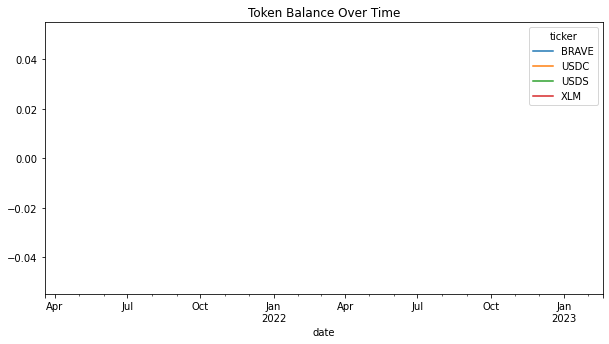

In [ ]:
# convert the original dataframe to timezone-naive datetime object
df['created_at'] = df['time'].dt.floor('1D')

# group the transactions by ticker, time, and transaction type, and pivot the table to create separate columns for deposits and withdrawals
agg_df = df.groupby(['amountTicker', 'time', 'transactionType'], as_index=False)['amount'].sum().pivot_table(index=['amountTicker', 'time'], columns='transactionType', values='amount', fill_value=0)

# calculate the net balance (deposits - withdrawals) for each ticker and day
agg_df['balance'] = agg_df['deposit'] - agg_df['withdrawal']
agg_df.reset_index(inplace=True)

# create an index with all unique combinations of tickers and days
tickers = agg_df['amountTicker'].unique()
dates = pd.date_range(df['created_at'].min().date(), df['created_at'].max().date(), freq='D', tz='UTC')
index = pd.MultiIndex.from_product([tickers, dates], names=['ticker', 'date'])

# create a new dataframe with the balance for each ticker and day
balance_df = pd.DataFrame(index=index).reset_index()
# balance_df['date'] = balance_df['date'].dt.tz_localize('UTC')

# merge the balance dataframe with the aggregated dataframe to get the balance for each ticker and day
merged_df = pd.merge(balance_df, agg_df, how='left', left_on=['ticker', 'date'], right_on=['amountTicker', 'time'])

merged_df['balance'] = merged_df.groupby('ticker')['balance'].cumsum()
pivot_df = merged_df.pivot(index='date', columns='ticker', values='balance')

pivot_df.plot(figsize=(10, 5), title='Token Balance Over Time')



In [ ]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=3699a0f2d42e69c15f24d3a0c25fd567c7b34ae610083763e3e129aa13b6b345
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [ ]:
import pandas as pd
import datetime


start_date = datetime.date(2021, 3, 23)
end_date = datetime.date.today()

days = pd.date_range(start=start_date, end=end_date, freq='D')
days = pd.DataFrame({'day': days})

In [ ]:
def reconcile(df):
  start_date = datetime.date(2021, 3, 23)
  end_date = datetime.date.today()

  days = pd.date_range(start=start_date, end=end_date, freq='D')
  days = pd.DataFrame({'day': days})

In [ ]:

from pandasql import sqldf

# create a sample dataframe
# df = pd.DataFrame({
#     'name': ['Alice', 'Bob', 'Charlie'],
#     'age': [25, 30, 35],
#     'country': ['USA', 'Canada', 'Mexico']
# })

# define a SQL query
query = """
WITH transfers AS (
  SELECT strftime('%Y-%m-%d %H:%M:%S', time) AS time,
        SUM(amount) AS amount,
        amountTicker
  FROM (
    SELECT strftime('%Y-%m-%d %H:%M:%S', time, 'start of day') AS time,
          amount,
          amountTicker
    FROM df
    WHERE transactionType = 'deposit'

    UNION ALL

    SELECT strftime('%Y-%m-%d %H:%M:%S', time, 'start of day') AS time,
          -amount AS amount,
          amountTicker
    FROM df
    WHERE transactionType = 'withdrawal'
  ) sub
  GROUP BY 1, 3)

, balances_with_gap_days AS (
     SELECT
        time
        ,amountTicker
        ,SUM(amount) OVER (PARTITION BY amountTicker ORDER BY time ASC) AS balance
       ,LEAD(time, 1, CURRENT_TIMESTAMP) OVER (PARTITION BY amountTicker ORDER BY time ASC) AS next_day
     FROM transfers
     )


, balance_all_days AS (
     SELECT
        d.day AS time
        ,amountTicker
        ,SUM(balance) AS balance
     FROM balances_with_gap_days b
     INNER JOIN days d ON b.time <= d.day
     AND d.day < b.next_day -- Yields an observation for every day after the first transfer until the next day with transfer
     GROUP BY 1,2
     ORDER BY 1,2
     )
SELECT * FROM balance_all_days;

"""

# execute the SQL query on the dataframe
result = sqldf(query, locals())

result_df = pd.DataFrame(result)

result_df

,time,amountTicker,balance
0,2021-03-23 00:00:00.000000,USDC,100.000000
1,2021-03-23 00:00:00.000000,XLM,250.000000
2,2021-03-24 00:00:00.000000,USDC,100.000000
3,2021-03-24 00:00:00.000000,XLM,250.000000
4,2021-03-25 00:00:00.000000,USDC,100.000000
...,...,...,...
2368,2023-02-25 00:00:00.000000,XLM,2337.113946
2369,2023-02-26 00:00:00.000000,BRAVE,1.000000
2370,2023-02-26 00:00:00.000000,USDC,65783.879200
2371,2023-02-26 00:00:00.000000,USDS,106214.024487


<AxesSubplot:title={'center':'Token Balance Over Time'}, xlabel='time'>

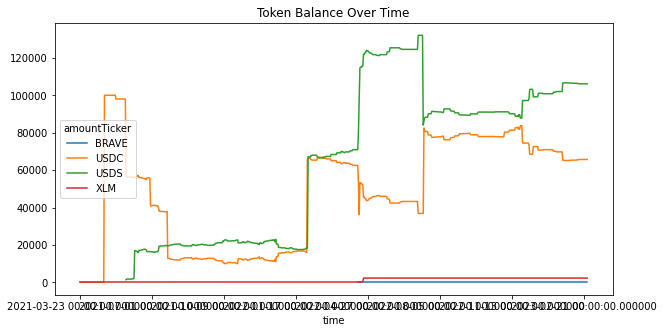

In [ ]:
pivot_df = result_df.pivot(index='time', columns='amountTicker', values='balance')

pivot_df.plot(figsize=(10, 5), title='Token Balance Over Time')


In [ ]:
import plotly.express as px
pivot_df = pivot_df.reset_index()
melt_df = pivot_df.melt(id_vars='time', var_name='amountTicker', value_name='balance')
fig = px.line(melt_df, x='time', y='balance', color='amountTicker', title='Token Balance Over Time')
fig.show()


In [ ]:
fig = px.line(result_df, x='time', y='balance', color='amountTicker', title='Token Balance Over Time')
fig.show()

In [ ]:
result_df.dtypes

time             object
amountTicker     object
balance         float64
dtype: object

In [ ]:
# Group by month and amountTicker, and aggregate balance by first and last value
result_df['time'] = pd.to_datetime(result_df['time'])

monthly_balances = result_df.groupby([result_df['time'].dt.to_period('M'), 'amountTicker'])['balance'].agg(['first', 'last'])

# Reset index to get a DataFrame with columns for month, amountTicker, first balance, and last balance
monthly_balances = monthly_balances.reset_index()

# Rename columns
monthly_balances = monthly_balances.rename(columns={'time': 'month'})


In [ ]:
monthly_balances.loc[monthly_balances['amountTicker'] == 'USDC']

,month,amountTicker,first,last
0,2021-03,USDC,100.000000,100.000000
2,2021-04,USDC,100.000000,100100.150002
4,2021-05,USDC,100100.150002,56421.721820
7,2021-06,USDC,56421.721820,40948.191190
10,2021-07,USDC,41017.530791,12152.364060
13,2021-08,USDC,12138.642943,12965.078240
16,2021-09,USDC,12958.081049,11710.938887
19,2021-10,USDC,11598.860709,12601.815290
22,2021-11,USDC,12601.815290,13144.938186
25,2021-12,USDC,13143.352727,15859.299630


In [ ]:

new_df = payment_df.loc[payment_df['amountTicker'] == 'USDC']

new_df['amount'] = pd.to_numeric(new_df['amount'])

# add "amount_signed" column
new_df['amount_signed'] = new_df['amount']
new_df.loc[new_df['transactionType'] == 'withdrawal', 'amount_signed'] *= -1

# sort by "created_at" column in ascending order
new_df = new_df.sort_values('created_at', ascending=True)

# add "cumulative_amount" column
new_df['cumulative_amount'] = new_df.groupby('amountTicker')['amount_signed'].cumsum()

new_df

# add "balance" column and set initial value to 0
# new_df['balance'] = 0


#iterate through each row and update "balance" column based on "transactionType"
# balance = 0
# for index, row in new_df.iterrows():
#     if row['transactionType'] == 'deposit':
#         balance += row['amount']
#     elif row['transactionType'] == 'withdrawal':
#         balance -= row['amount']
#     new_df.loc[index, 'balance'] = balance

# new_df


<ipython-input-28-44b65c5281fc>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-44b65c5281fc>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,created_at,public_key,amount,amountTicker,transaction_hash,transactionType,amount_signed,cumulative_amount
1,2021-03-23 08:45:41+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e+02,USDC,fd464175cb95799e9c6039b02a1a9e46b878140b3fce0f...,deposit,1.000000e+02,1.000000e+02
15,2021-04-03 12:16:35+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,48b0b7d3121cd366ba5719ba7a52861ad450d6e7dbaa85...,deposit,1.000000e-07,1.000000e+02
16,2021-04-03 12:40:58+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,4228b22368bf209fba69783c976f598d23161cae91442f...,deposit,1.000000e-07,1.000000e+02
17,2021-04-03 13:35:46+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,63aacd95b5c0a1bbd18c42b8a4f3bd06f8315cf11c615f...,deposit,1.000000e-07,1.000000e+02
18,2021-04-03 14:00:48+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,5b8e4b2fce528eb15e6f697ae843fc0980b427c43f3676...,deposit,1.000000e-07,1.000000e+02
19,2021-04-05 11:09:29+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,113718179d37ff476179baec36de1517e7aa0185c867aa...,deposit,1.000000e-07,1.000000e+02
20,2021-04-05 11:18:33+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,e08e29083c6fb8140e6d23385c7f8b4f0e01a3d8a34472...,deposit,1.000000e-07,1.000000e+02
21,2021-04-05 11:25:14+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,f2af9f709fbf3fa148a839466950c172fb1460879f7984...,deposit,1.000000e-07,1.000000e+02
22,2021-04-05 11:31:40+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,fc9b46a0e4bdaf1fa460e43dbd71016d5d6e00b4dc54d6...,deposit,1.000000e-07,1.000000e+02
23,2021-04-05 11:42:10+00:00,GCQJVAXWHB23WBNIG7TWEWHWUGGB6HWBC2ASPF5HMSADO5...,1.000000e-07,USDC,6b3d38874c6f4912552d88a0cc08422a56a12a01070ce2...,deposit,1.000000e-07,1.000000e+02


COMPARE CSVs FROM Stellar Expert

In [ ]:
# df_1 = pd.read_csv('/content/income-2021-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7 (5).csv')
# df_2 = pd.read_csv('/content/income-2022-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7 (5).csv')
# df_3 = pd.read_csv('/content/spending-2021-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7 (4).csv')
# df_4 = pd.read_csv('/content/spending-2022-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7 (3).csv')
# df_5 = pd.read_csv('/content/income-2023-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7.csv')
# df_6 = pd.read_csv('/content/spending-2023-GDDGK5C7UQWC7AEFZZVO7KXRXZVP2BBQJ2IQFAIROKME2O3XQR2CMVC7.csv')

# df_union = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])

# spend_rows = df_union['Action'] == 'SPEND'

# df_union.loc[spend_rows, 'Volume'] = -df_union.loc[spend_rows, 'Volume']

# df_test = df_union.groupby('Symbol')['Volume'].sum().reset_index()

# df_test


In [ ]:
df_union.shape[0]

NameError: ignored

In [ ]:
df_union

In [ ]:
not_in_union = df_union[~df_union['TxHash'].isin(rec['transaction_hash'])]

In [ ]:
not_in_union.shape[0]

In [ ]:
not_in_union

In [ ]:
#@title Reconcile

def reconcile(df):


  df.loc[df['transactionType'] == 'withdrawal', 'amount'] = -df['amount']

  df = df.groupby('amountTicker')['amount'].sum().reset_index()

  return df

In [ ]:
reconcile(rec)

In [ ]:
reconcile(rec)

In [ ]:
# import plotly.express as px

# result['week_ending'] = result['created_at'].dt.to_period('W').apply(lambda x: x.end_time)
# df_grouped = result.groupby(result['week_ending'].dt.date).count()

# fig = px.bar(df_grouped, x=df_grouped.index, y='created_at')
# fig.update_layout(xaxis_title='Week Ending', yaxis_title='Count')
# fig.show()





In [ ]:
withdrawals = result[result['transactionType'] == 'withdrawal']
deposits = result[result['transactionType'] == 'deposit']

withdrawals['amount'] = -pd.to_numeric(withdrawals['amount'], errors='coerce')
withdrawals['amount'] = -withdrawals['amount']

sub = pd.concat([withdrawals, deposits], ignore_index=True)
sub = sub.sort_values(by=['created_at', 'amountTicker'])
sub['running_balance'] = sub.groupby('amountTicker')['amount'].cumsum()
sub = sub.reset_index(drop=True)

In [ ]:
import plotly.express as px

sub = sub.sort_values(by=['created_at', 'amountTicker'])
sub['running_balance'] = sub.groupby('amountTicker')['amount'].cumsum()

fig = px.line(sub, x='created_at', y='running_balance', color='amountTicker')
fig.show()


In [ ]:
september_20th = result[result['created_at'].dt.day == 8]
september_20th = september_20th[september_20th['created_at'].dt.month == 9]
september_20th

In [ ]:
sub = sub.groupby('amountTicker')['amount'].sum().reset_index()


In [ ]:
sub